## Model Part 4 (Model V1)

In this part, we will explore the behavior of uncertainty (14 day STD) on individual stocks. So, what you should expect is a lot of "generic" code for processing the whole folders (35 files) because we cannot do it by hand unfortunately! Specifically, we will do multiple linear regression of future 14 day STD on three independent variables: past 14 day STD (lagged variable), (price - prev 14 day MA)^2 (error squared), error_squared *indicator r.v. (positive/negative shock)*. As you can notice, this is similar to GJR Garch, but since I think scikit-learn package is more feasible to do "generic" coding, so I will use my own proxy for variance (STD-14). 

In [1]:
import pandas as pd
import numpy as np

In [2]:
PRICE_FILES = ["data/Stocks/AlternativeEnergy_Price.csv", "data/Stocks/Automobile_Price.csv", "data/Stocks/Bank_Price.csv",
                        "data/Stocks/Beverage_Price.csv", "data/Stocks/BioTech_Price.csv", "data/Stocks/Chemical_Price.csv",
                        "data/Stocks/Construction_Price.csv", "data/Stocks/Electricity_Price.csv", "data/Stocks/Electronic_Price.csv",
                        "data/Stocks/Finance_Price.csv", "data/Stocks/Fix_Price.csv", "data/Stocks/Food_Price.csv", 
                        "data/Stocks/FoodProducer_Price.csv", "data/Stocks/Gas_Price.csv", "data/Stocks/GeneralIndustrial_Price.csv",
                        "data/Stocks/GeneralRetail_Price.csv", "data/Stocks/Hardware_Price.csv", "data/Stocks/Health_Price.csv",
                        "data/Stocks/Household_Price.csv", "data/Stocks/IndustrialEngineer_Price.csv", "data/Stocks/IndustrialMetal_Price.csv", 
                        "data/Stocks/IndustrialTransport_Price.csv", "data/Stocks/Insurance_Price.csv", "data/Stocks/Leisure_Price.csv",
                        "data/Stocks/Media_Price.csv", "data/Stocks/Mining_Price.csv", "data/Stocks/NonLifeInsure_Price.csv",
                        "data/Stocks/OilProducer_Price.csv", "data/Stocks/Paper_Price.csv", "data/Stocks/PersonalGoods_Price.csv",
                        "data/Stocks/RealEstate_Price.csv", "data/Stocks/Software_Price.csv", "data/Stocks/Support_Price.csv",
                        "data/Stocks/Travel_Price.csv", "data/Stocks/Unclassified_Price.csv"]

VOLUME_FILES = ["data/Stocks/AlternativeEnergy_Volume.csv", "data/Stocks/Automobile_Volume.csv", "data/Stocks/Automobile_Volume.csv",
                           "data/Stocks/Beverage_Volume.csv", "data/Stocks/BioTech_Volume.csv", "data/Stocks/Chemical_Volume.csv",
                           "data/Stocks/Construction_Volume.csv", "data/Stocks/Electricity_Volume.csv", "data/Stocks/Electronic_Volume.csv",
                           "data/Stocks/Finance_Volume.csv", "data/Stocks/Fix_Volume.csv", "data/Stocks/Food_Volume.csv", 
                           "data/Stocks/FoodProducer_Volume.csv", "data/Stocks/Gas_Volume.csv", "data/Stocks/GeneralIndustrial_Volume.csv",
                           "data/Stocks/GeneralRetail_Volume.csv", "data/Stocks/Hardware_Volume.csv", "data/Stocks/Health_Volume.csv", 
                           "data/Stocks/Household_Volume.csv", "data/Stocks/IndustrialEngineer_Volume.csv", "data/Stocks/IndustrialMetal_Volume.csv", 
                           "data/Stocks/IndustrialTransport_Volume.csv", "data/Stocks/Insurance_Volume.csv", "data/Stocks/Leisure_Volume.csv",
                           "data/Stocks/Media_Volume.csv", "data/Stocks/Mining_Volume.csv", "data/Stocks/NonLifeInsure_Volume.csv",
                           "data/Stocks/OilProducer_Volume.csv", "data/Stocks/Paper_Volume.csv", "data/Stocks/PersonalGoods_Volume.csv",
                           "data/Stocks/RealEstate_Volume.csv", "data/Stocks/Software_Volume.csv", "data/Stocks/Support_Volume.csv",
                           "data/Stocks/Travel_Volume.csv", "data/Stocks/Unclassified_Volume.csv"]

In [3]:
def RenameHeader(col_name, col_type):
    if col_name == "Code":
        return "Code"
    else:
        if col_type == "Price":
            return col_name[2:-3]
        else:
            return col_name[2:-4]

In [4]:
def Clean(price, volume):
    
    """
    Argument: price dataframe and volume dataframe
    Return: return the tuples of price dataframes (2014-2019) and volume dataframes (2014-2019)
                where each one of them is filtered out missing col, missing price from prev year, missing vol from prev year,
                        no volume traded occurs from prev year
    Note: this function requires RenameHeader (Defined above) and pandas
    """
    
    # Read two dataframes and filter to have files from 2014 to 2019
    price_df = pd.read_csv(price).rename(columns = lambda x: RenameHeader(x, "Price"))
    price_df['Code'] = pd.to_datetime(price_df['Code'])
    price_df = price_df[(price_df['Code'] > '2014-01-01') & (price_df['Code'] < '2020-01-01')]
    
    vol_df = pd.read_csv(volume).rename(columns = lambda x: RenameHeader(x, "Vol"))
    vol_df['Code'] = pd.to_datetime(vol_df['Code'])
    vol_df = vol_df[(vol_df['Code'] > '2014-01-01') & (vol_df['Code'] < '2020-01-01')]
    
    # Use only common cols in two dataframes
    common_cols = price_df.columns.intersection(vol_df.columns).tolist()
    price_df = price_df[common_cols]
    vol_df = vol_df[common_cols]
    
    # Temporarily include SET_VOL to filter holidays
    SET_IDX_VOL = pd.read_csv('data/SET/SET_VO.csv', parse_dates = True)
    SET_IDX_VOL = SET_IDX_VOL.rename(columns = {'Code': 'Code', 'BNGKSET(VO)': 'Volume'})
    SET_IDX_VOL['Code'] = pd.to_datetime(SET_IDX_VOL['Code'])
    
    # Filter holiday on price dataframes
    price_df = pd.merge(price_df, SET_IDX_VOL, how = 'inner', on = 'Code')
    price_df = price_df[price_df['Volume'].notna()]
    price_df.drop(['Volume'], axis = 1, inplace = True)
    
    # Filter holiday on price dataframes
    vol_df = pd.merge(vol_df, SET_IDX_VOL, how = 'inner', on = 'Code')
    vol_df = vol_df[vol_df['Volume'].notna()]
    vol_df.drop(['Volume'], axis = 1, inplace = True)
    
    # loop from 2014 to 2019 to create small dataframes (useful for filtering later on)
    price_df_s = []
    vol_df_s = []
    for i in range(6):
        x = i + 2014
        start_date = str(x) + '-01-01'
        end_date = str(x+1) + '-01-01'
        price_df_s.append(price_df[(price_df['Code'] > start_date) & (price_df['Code'] < end_date)])
        vol_df_s.append(vol_df[(vol_df['Code'] > start_date) & (vol_df['Code'] < end_date)])
        
    # Filter the columns from 2015 to 2019 by two criterias
    # 1) Any missing price variables from previous year
    # 2) Any missing + zero volume from previous year
    for i in range(5):
        
        price_filter_df = price_df_s[i]
        vol_filter_df = vol_df_s[i]
        
        price_null = price_filter_df.columns[price_filter_df.isna().any()].tolist()
        vol_null = vol_filter_df.columns[vol_filter_df.isna().any()].tolist()
        # Create another copy (a bit inefficient, but it works)
        vol_temp = vol_filter_df.drop(['Code'], axis = 1, inplace = False)
        vol_gt_zero = vol_temp.columns[(vol_temp <= 0).any()].tolist()
        
        filtered_out_col = list(set().union(price_null,vol_null,vol_gt_zero))
        
        price_df_s[i+1].drop(filtered_out_col, axis = 1, inplace = True)
        vol_df_s[i+1].drop(filtered_out_col, axis = 1, inplace = True)
        
        
    return (price_df_s, vol_df_s)
        

In [5]:
def GenerateFeatures(price_list, vol_list):
    """
    Input: price dataframes list, vol dataframes list
    Return: list of list of dict
    (for example, [automobile, ...] -> [2014, 2015, 2016, ...] -> {price: price_df, vol: vol_df, feature1: ...})
    """
    return_list = []
    for i in range(len(price_list)):
        compile_list = []
        price_df_s, vol_df_s = Clean(price_list[i], vol_list[i])
        
        for j in range(len(price_df_s)):
            sub_dict = {}
            price_df = price_df_s[j]
            vol_df = vol_df_s[j]
            
            ## Define new dataframes: this records the 14-day variance forward (dependent variables)
            y_df = pd.DataFrame(index=price_df.index, columns=price_df.columns)
            y_df['Code'] = price_df['Code']
            ## Define new dataframes: lagged dependent variable: previous 14-day variance forward
            y_lag_df = pd.DataFrame(index=price_df.index, columns=price_df.columns)
            y_lag_df['Code'] = price_df['Code']
            ## Define new dataframes: this records error square
            error_sq_df = pd.DataFrame(index=price_df.index, columns=price_df.columns)
            error_sq_df['Code'] = price_df['Code']
            ## Define new dataframes: this records indicator * error_square
            error_ind_df = pd.DataFrame(index=price_df.index, columns=price_df.columns)
            error_ind_df['Code'] = price_df['Code']            
            
            
            for col in list(price_df.columns):
                if col != 'Code':
                    # Calculate rolling 14 days variance to be put in y_lag_df
                    y_lag_df[col] = price_df.loc[:, col].rolling(14).var()
                    # Shift this col up by 13 days to be put in y_df (future predictions)
                    y_df[col] = y_lag_df[col].shift(-14)
                    # Calculate the error by subtracting the current price by  previous 14-day MA
                    err = price_df.loc[:, col] -  price_df.loc[:, col].rolling(14).mean().shift(1)
                    # Calculate the sign of error term (indicator r.v.)
                    err_dir = err.apply(lambda x: 1 if x > 0 else 0)
                    # Calculate square of error to be another variable in error_sq_df
                    error_sq_df[col] = err ** 2
                    # Calculate the Indicator*error_sq
                    error_ind_df[col] = error_sq_df[col] * err_dir
                    
            
            sub_dict['price'] = price_df
            sub_dict['vol'] = vol_df
            sub_dict['var'] = y_df
            sub_dict['var_lag'] = y_lag_df
            sub_dict['error_sq'] = error_sq_df
            sub_dict['error_ind'] = error_ind_df
            compile_list.append(sub_dict)
            
        return_list.append(compile_list)
        
    return return_list
        

In [6]:
def Rearrange(sector_list):
    """
    Input: sector_list (return list from GenerateFeatures function above)
    Return: list of list of dict as follows
        [2014, 2015, 2016, ...] -> {key: PTT, data: dataframes}
        (similar how we usually render in React)
    """
    # Each sublist is for each year
    return_list = [[], [], [], [], [], []]
    
    # i runs from 0 to # of sectors - 1
    for i in range(len(sector_list)):
        sector_stocks = sector_list[i]
        # j runs from 0 to 5 (0 -> 2014, 5 -> 2019)
        for j in range(6):
            sector_year_dict = sector_stocks[j]
            col_names = sector_year_dict['price'].columns.tolist()
            # k runs for each column except "Code"
            for k in range(1, len(col_names)):
                stock_name = col_names[k]
                # Step 1: create blank dataframes
                new_data = pd.DataFrame(index=sector_year_dict['price'].index, columns= ['Code', 'vol', 'price', 'lag_y', 'error_sq', 'error_signed', 'y'])
                new_data['Code'] = sector_year_dict['price']['Code']
                # Step 2: Retrieve data from the key and insert it into new_data
                new_data['vol'] = sector_year_dict['vol'].loc[:, stock_name]
                new_data['price'] = sector_year_dict['price'].loc[:, stock_name]
                new_data['lag_y'] = sector_year_dict['var_lag'].loc[:, stock_name]
                new_data['error_sq'] = sector_year_dict['error_sq'].loc[:, stock_name]
                new_data['error_signed'] = sector_year_dict['error_ind'].loc[:, stock_name]
                new_data['y'] = sector_year_dict['var'].loc[:, stock_name]
                # Step 3: Drop rows with at least one missing value
                new_data.dropna(axis = 0, how = 'any', inplace = True)
                # Step 4: Insert the new_dataframe into appropriate place (notice we use dict for convenience later)
                new_dict = {'key': stock_name, 'data': new_data}
                return_list[j].append(new_dict)
                
    return return_list
    

In [7]:
def GetVolumeTraded(RenderList):
    """
    input: RenderList, using the same data structure corresponding to Rearrange function (defined above)
    Process: Add key of volume_traded in each stock-year (calculated from last year)
    Return: nothing
    """
    # For each year from 2015 to 2019
    for i in range(1, 6):
        
        # For each stock that we want to add the new key: volume traded
        for stock in RenderList[i]:
            stock_name = stock['key']
            
            prev_data = RenderList[i-1]
            
            # This is inefficient, but it's okay, because otherwise, we need to change the whole data structure
            for prev_stock in prev_data:
                if prev_stock['key'] == stock_name:
                    # Calculate the latest volume in last year
                    stock['volume_traded'] = prev_stock['data'].loc[:, 'vol'].iloc[-1]
                    
            
        

In [8]:
def RemoveNoKey(RenderList, key):
    remove_keys = []
    
    for entry in RenderList:
        if key not in entry:
            remove_keys.append(entry["key"]) # Append stock abbreviations we want to remove
            
    if len(remove_keys) == 0:
        return RenderList
    else:
        return [x for x in RenderList if x["key"] not in remove_keys]

In [12]:
cleaned_dfs = GenerateFeatures(PRICE_FILES, VOLUME_FILES)
RenderList = Rearrange(cleaned_dfs)
GetVolumeTraded(RenderList)
volume_histograms = []

for i in range(1,6):
    stock_list = RemoveNoKey(RenderList[i], 'volume_traded')
    stock_list = sorted(stock_list, key = lambda x: x['volume_traded'])
    volume_hist = [x['volume_traded'] for x in stock_list]
    volume_histograms.append(volume_hist)



C:\Users\User\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [22]:
STD_histograms = []

for i in range(1,6):
    stock_list = RemoveNoKey(RenderList[i], 'volume_traded')
    stock_list = sorted(stock_list, key = lambda x: x['volume_traded'])
    volume_hist = [x['data']['y'].mean() for x in stock_list]
    STD_histograms.append(volume_hist)

Text(0.5, 1.0, 'Histogram on volume traded year 2014')

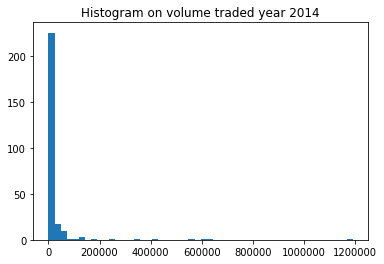

In [17]:
import matplotlib.pyplot as plt
n_bins = 50
fig, ax = plt.subplots()
ax.hist(volume_histograms[0], bins = n_bins)
plt.title('Histogram on volume traded year 2014')

Text(0.5, 1.0, 'Histogram on volume traded year 2015')

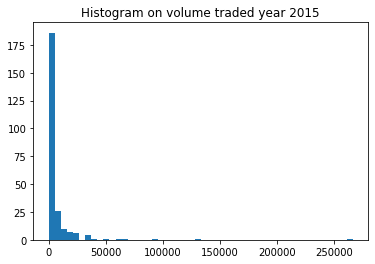

In [18]:
import matplotlib.pyplot as plt
n_bins = 50
fig, ax = plt.subplots()
ax.hist(volume_histograms[1], bins = n_bins)
plt.title('Histogram on volume traded year 2015')

Text(0.5, 1.0, 'Histogram on volume traded year 2016')

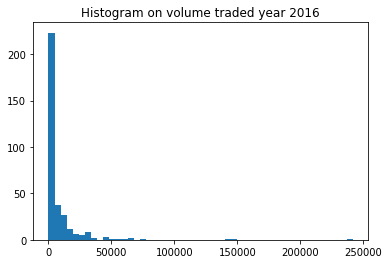

In [19]:
import matplotlib.pyplot as plt
n_bins = 50
fig, ax = plt.subplots()
ax.hist(volume_histograms[2], bins = n_bins)
plt.title('Histogram on volume traded year 2016')

Text(0.5, 1.0, 'Histogram on volume traded year 2019')

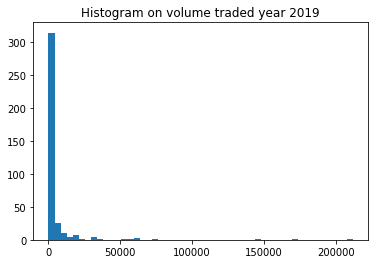

In [20]:
import matplotlib.pyplot as plt
n_bins = 50
fig, ax = plt.subplots()
ax.hist(volume_histograms[-1], bins = n_bins)
plt.title('Histogram on volume traded year 2019')

Text(0.5, 1.0, 'Histogram on STD_14 year 2014')

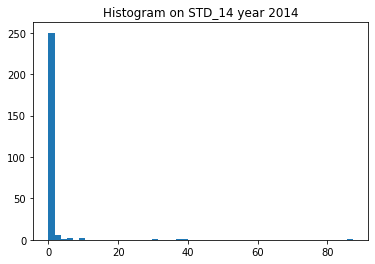

In [24]:
import matplotlib.pyplot as plt
n_bins = 50
fig, ax = plt.subplots()
ax.hist(STD_histograms[0], bins = n_bins)
plt.title('Histogram on STD_14 year 2014')

Text(0.5, 1.0, 'Histogram on STD_14 year 2019')

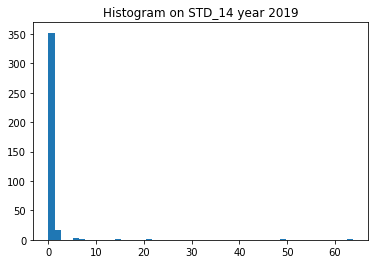

In [23]:
import matplotlib.pyplot as plt
n_bins = 50
fig, ax = plt.subplots()
ax.hist(STD_histograms[-1], bins = n_bins)
plt.title('Histogram on STD_14 year 2019')

In [25]:
x = []
y = []
for i in range(1,6):
    stock_list = RemoveNoKey(RenderList[i], 'volume_traded')
    stock_list = sorted(stock_list, key = lambda x: x['volume_traded'])
    volume_hist = [x['volume_traded'] for x in stock_list]
    STD_hist = [x['data']['y'].mean() for x in stock_list]
    x.append(volume_hist)
    y.append(STD_hist)

Text(0.5, 1.0, 'scatter plot on volume traded and average STD year 2014')

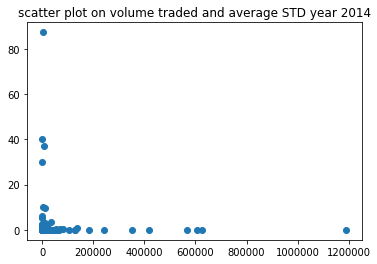

In [27]:
fig, ax = plt.subplots()
ax.scatter(x[0], y[0])
plt.title('scatter plot on volume traded and average STD year 2014')

Text(0.5, 1.0, 'scatter plot on volume traded and average STD year 2019')

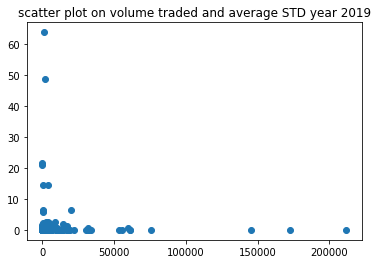

In [28]:
fig, ax = plt.subplots()
ax.scatter(x[-1], y[-1])
plt.title('scatter plot on volume traded and average STD year 2019')

In [128]:
from sklearn.linear_model import LinearRegression

def GenerateTable(RenderList):
    """
    Input: RenderList, using the same data structure corresponding to Rearrange function and has the key volume_traded
    This will output the result of average coefficient across five years into csv file
    Return: nothing
    """
    # This is the return dataframe with three columns corresponding to each coefficient
    return_df = pd.DataFrame(index=range(10) , columns= ['lag_y', 'error_sq', 'error_signed'])
    return_df = return_df.fillna(0)
    
    for i in range(1, 6):
        ## For debug purpose
        print('We are at year ' + str(i))
        # Sort by volume traded and split into ten sub-lists
        stock_list = RemoveNoKey(RenderList[i], 'volume_traded')
        stock_list = sorted(stock_list, key = lambda x: x['volume_traded'])
        ten_splits = np.array_split(stock_list, 10)
        for j in range(10):
            ## For debug purpose
            print('---> We are at decile of ' + str(j) + ' consisting of '+ str(len(ten_splits[j])) + ' firms!')
            
            x1, x2, x3 = 0, 0, 0
            
            for Render in ten_splits[j]:
                combined_df = Render['data']
                combined_df.drop(['Code', 'vol', 'price'], axis = 1, inplace = True)
                X = combined_df[['lag_y', 'error_sq', 'error_signed']]
                y = combined_df['y']
                
                model = LinearRegression().fit(X, y)
                model_coef = model.coef_
                
                lag_y, error_sq, error_signed = model_coef[0], model_coef[1], model_coef[2]
                x1 = x1 + lag_y
                x2 = x2 + error_sq
                x3 = x3 + error_signed
                
            return_df.loc[j, 'lag_y'] = return_df.loc[j, 'lag_y'] + (x1/len(ten_splits[j]))
            return_df.loc[j, 'error_sq'] = return_df.loc[j, 'error_sq'] + (x2/len(ten_splits[j]))
            return_df.loc[j, 'error_signed'] = return_df.loc[j, 'error_signed'] + (x3/len(ten_splits[j]))
                
            #combined_df = pd.concat([x['data'] for x in ten_splits[j]])
           #combined_df.drop(['Code', 'vol', 'price'], axis = 1, inplace = True)
            #X = combined_df[['lag_y', 'error_sq', 'error_signed']]
            #y = combined_df['y']
            
            # Run multiple linear regression here
            #model = LinearRegression().fit(X, y)
            #model_coef = model.coef_
            
            # Insert model_coef in return_df
            #lag_y, error_sq, error_signed = model_coef[0], model_coef[1], model_coef[2]
            #return_df.loc[j, 'lag_y'] = return_df.loc[j, 'lag_y'] + lag_y
            #return_df.loc[j, 'error_sq'] = return_df.loc[j, 'error_sq'] + error_sq
            #return_df.loc[j, 'error_signed'] = return_df.loc[j, 'error_signed'] + error_signed
            
    # Get average value
    return_df['lag_y'] = return_df['lag_y']/5
    return_df['error_sq'] = return_df['error_sq']/5
    return_df['error_signed'] = return_df['error_signed']/5
    
    return_df.to_csv('Model_V1_Result_3.csv')
    

In [129]:
cleaned_dfs = GenerateFeatures(PRICE_FILES, VOLUME_FILES)
RenderList = Rearrange(cleaned_dfs)
GetVolumeTraded(RenderList)
GenerateTable(RenderList)

C:\Users\User\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


We are at year 1
---> We are at decile of 0 consisting of 27 firms!
---> We are at decile of 1 consisting of 27 firms!
---> We are at decile of 2 consisting of 27 firms!
---> We are at decile of 3 consisting of 27 firms!
---> We are at decile of 4 consisting of 27 firms!
---> We are at decile of 5 consisting of 26 firms!
---> We are at decile of 6 consisting of 26 firms!
---> We are at decile of 7 consisting of 26 firms!
---> We are at decile of 8 consisting of 26 firms!
---> We are at decile of 9 consisting of 26 firms!
We are at year 2
---> We are at decile of 0 consisting of 25 firms!
---> We are at decile of 1 consisting of 25 firms!
---> We are at decile of 2 consisting of 25 firms!
---> We are at decile of 3 consisting of 25 firms!
---> We are at decile of 4 consisting of 25 firms!
---> We are at decile of 5 consisting of 25 firms!
---> We are at decile of 6 consisting of 24 firms!
---> We are at decile of 7 consisting of 24 firms!
---> We are at decile of 8 consisting of 24 firm

In [108]:
## This is the format of excel file that you should get. (This is not the real one; just for debugging)

,lag_y,error_sq,error_signed
0,0.020773,0.031523,-0.023770
1,0.136868,-0.033102,0.148192
2,-0.015657,-0.029460,0.144527
3,0.352925,0.001045,-0.073513
4,-0.004538,-0.004142,0.032461
5,-0.034629,-0.036425,0.021066
6,0.081072,-0.004273,0.127749
7,-0.001646,-0.039256,0.125487
8,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000


That was a lot to be explained as we have to run generic code to find suitable data structure to encapsulate all stocks and aggregate the results by using generic function to loop through all cleaned stocks! Also, I have to debug a lot when I come across this model.   
To sum up, what we should get is two excel files: Model_V1_Result.csv (combining all stocks in that decile into one model) and Model_V1_Result_3.csv (separately running LR on each stock and aggregate the result). In the next part, we will visualize the result as we did in part 3.